<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio de Gestión de Outliers

AutoRenew, la empresa líder en la venta de coches de segunda mano, sigue adelante con el desarrollo del modelo predictivo que ayudará a estimar el precio de los vehículos usados. Este modelo es clave para mejorar las estrategias de ventas, marketing y optimización del inventario de la empresa. Ya has realizado un análisis exploratorio inicial y gestionado los valores nulos en el conjunto de datos. Ahora, es el momento de abordar otro aspecto crucial del preprocesamiento: la **gestión de outliers**.

En este laboratorio, te enfocarás en identificar y gestionar los outliers (valores atípicos) presentes en el conjunto de datos. Los outliers pueden distorsionar los resultados de un análisis y afectar negativamente el rendimiento de los modelos predictivos, por lo que es fundamental tratarlos adecuadamente antes de proceder con las siguientes fases del proyecto.


**Instrucciones:**

1. **Identificación de Outliers:** Explora las columnas clave del conjunto de datos (como `price`, `powerCV`, `kilometer`, etc.) para identificar posibles outliers. Utiliza gráficos como diagramas de caja (boxplots) y análisis estadísticos para detectar valores que se desvíen significativamente del resto de los datos.

2. **Análisis de Outliers:** Una vez identificados, analiza los outliers para determinar si son errores de datos, valores extremos válidos o resultados de condiciones específicas que deben ser tenidos en cuenta. Considera el contexto de cada columna al evaluar la relevancia de estos valores atípicos.

3. **Gestión de Outliers:** Decide la estrategia más adecuada para manejar los outliers. Esto podría incluir la eliminación de los outliers, la transformación de los datos, o la aplicación de técnicas de imputación. Justifica tu elección basándote en cómo los outliers podrían afectar el modelo predictivo.

**Nota:** Recuerda que este laboratorio es parte de una serie de actividades en las que utilizarás el mismo conjunto de datos a lo largo de la semana. Documenta cuidadosamente los pasos que sigas para que puedas referirte a ellos en las próximas etapas del proyecto.


# 1. Identificación de Outliers

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import product, combinations

from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import os
import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.path.abspath('../'))
from src import funciones_soporte as fs
from src import funciones_outliers as fo

In [2]:
df = pd.read_csv("../datos/df_estandarizado.csv", index_col=0)

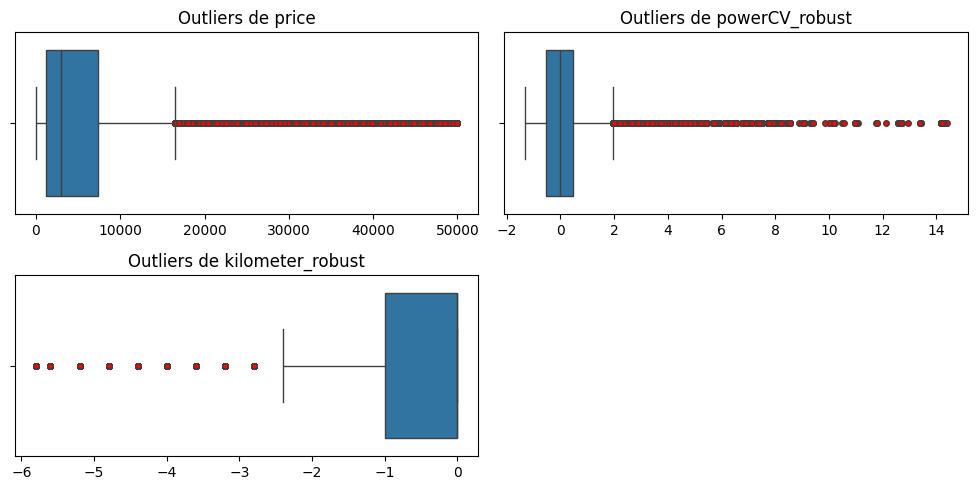

In [3]:
fs.detectar_outliers(df, False)

Como queremos detectar los outliers en el contexto del conjunto de los datos usaremos una gestión para detectar outliers multivariados. Como podemos observar para powerCV tenemos una gran cantidad de outliers bastante agrupados, por lo que la técnica que mejor debería funcionar para identificarlos sería el Local outlier factor ya que Isolation forest detecta valores atípicos que son raros y claramente diferentes al resto de los datos, lo cual no es nuestro caso.

In [4]:
columnas_numericas = df.select_dtypes(include=np.number)
columnas_numericas

price  powerCV_robust  kilometer_robust
0         480        0.072957               0.0
1       18300        1.098361              -1.0
2        9800        0.672131              -1.0
3        1500       -0.754098               0.0
4        3600       -0.852459              -2.4
...       ...             ...               ...
359179   2200        0.152342              -5.2
359180   1199       -0.327869              -1.0
359181   9200       -0.311475               0.0
359182   3400       -0.344262               0.0
359183  28990        3.213115              -4.0

[359184 rows x 3 columns]

In [5]:
# def gestion_nulos_lof(df, col_numericas, list_neighbors, lista_contaminacion):
    
#     combinaciones = list(product(list_neighbors, lista_contaminacion))
    
#     for neighbors, contaminacion in tqdm(combinaciones):
#         lof = LocalOutlierFactor(n_neighbors=neighbors, 
#                                  contamination=contaminacion,
#                                  n_jobs=-1)
#         df[f"outliers_lof_{neighbors}_{contaminacion}"] = lof.fit_predict(df[col_numericas])

#     return df

In [6]:
col_numericas=['powerCV_robust', 'kilometer_robust']
lista_vecinos=[5, 20, 50]
list_contaminacion = [0.01, 0.05, 0.1]

df_lof = df.copy()
df_lof = fo.gestion_nulos_lof(df_lof, col_numericas, lista_vecinos, list_contaminacion)


100%|██████████| 9/9 [08:28<00:00, 56.51s/it]


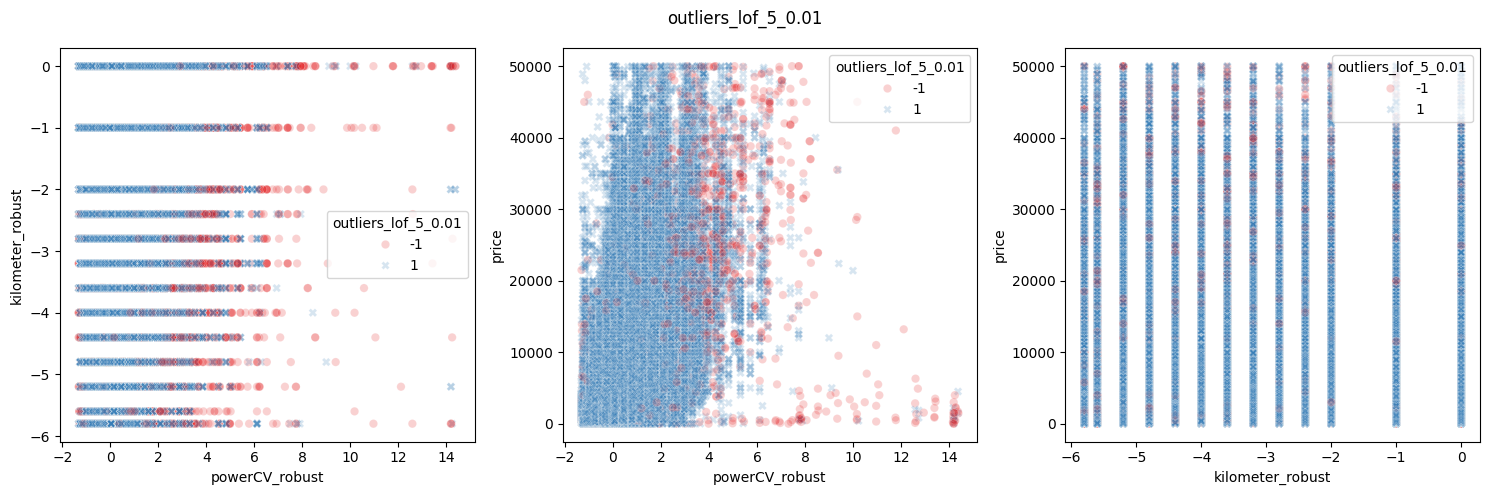

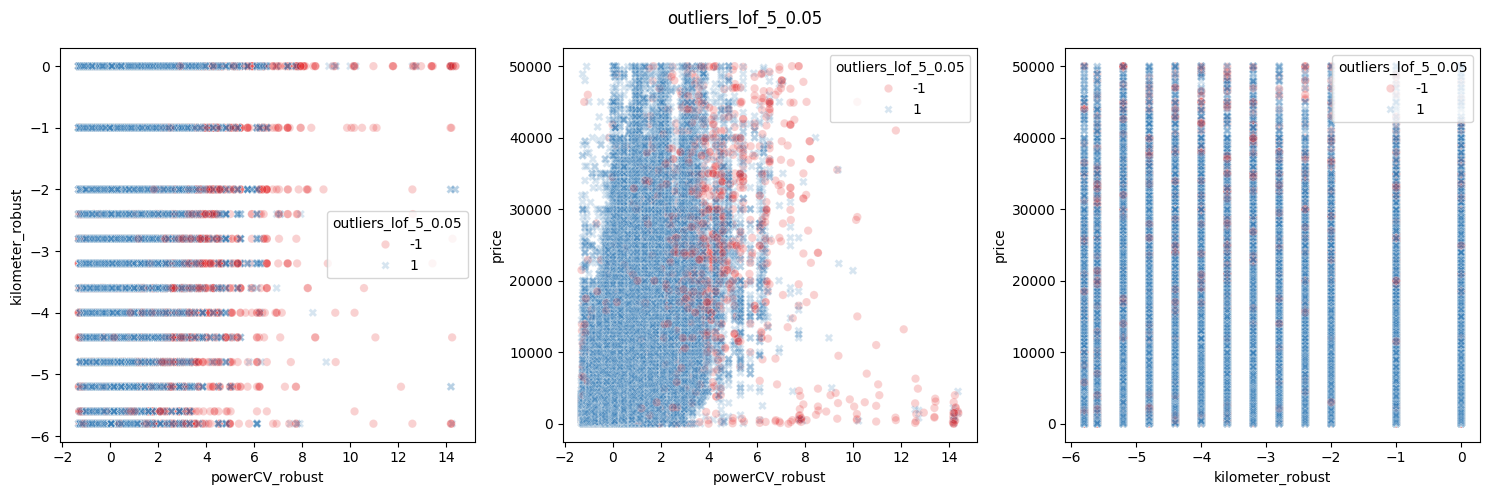

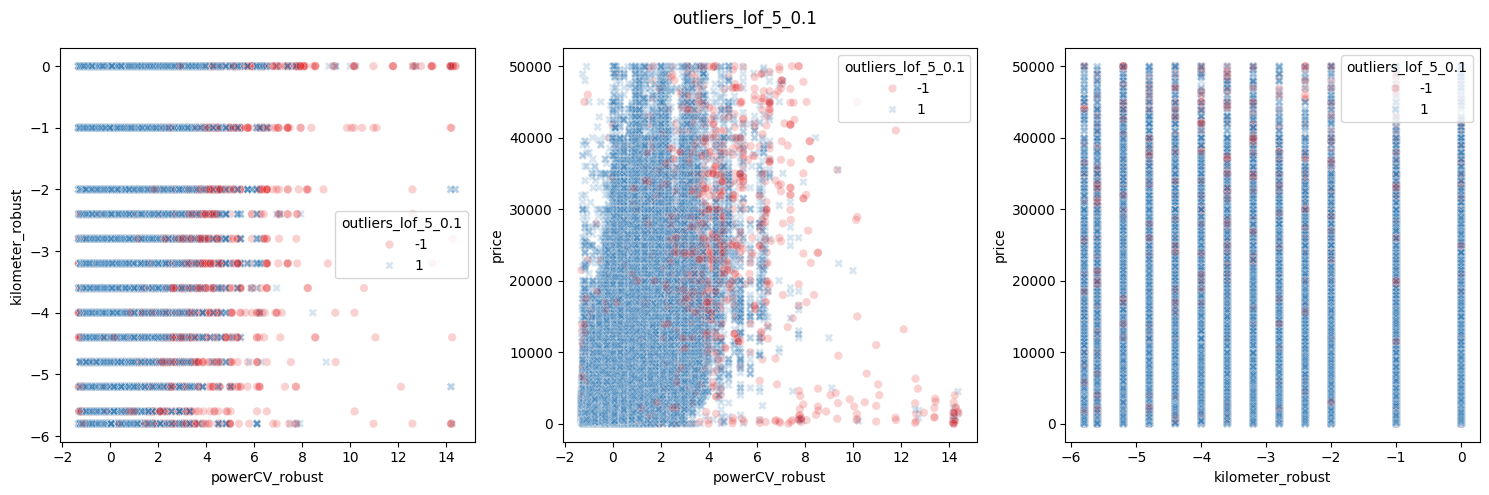

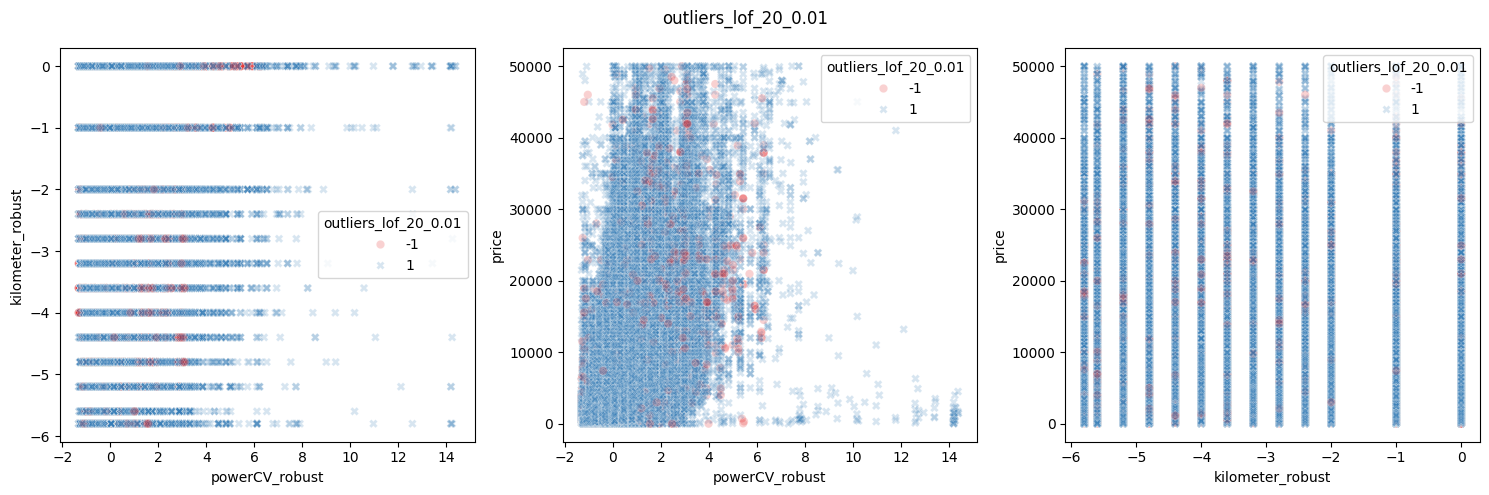

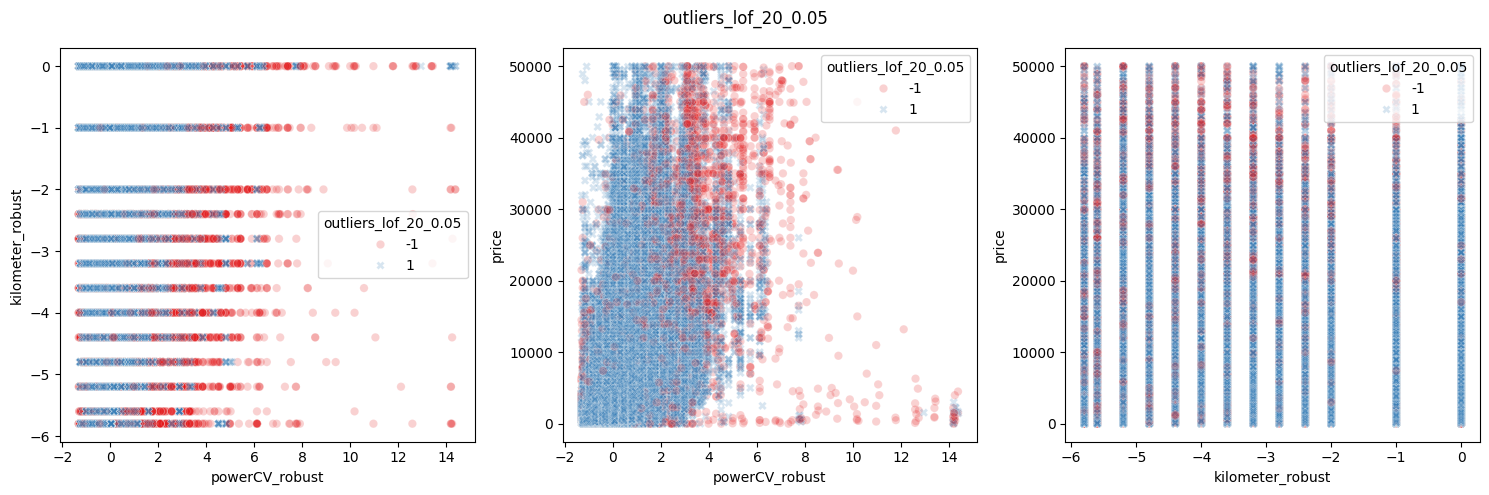

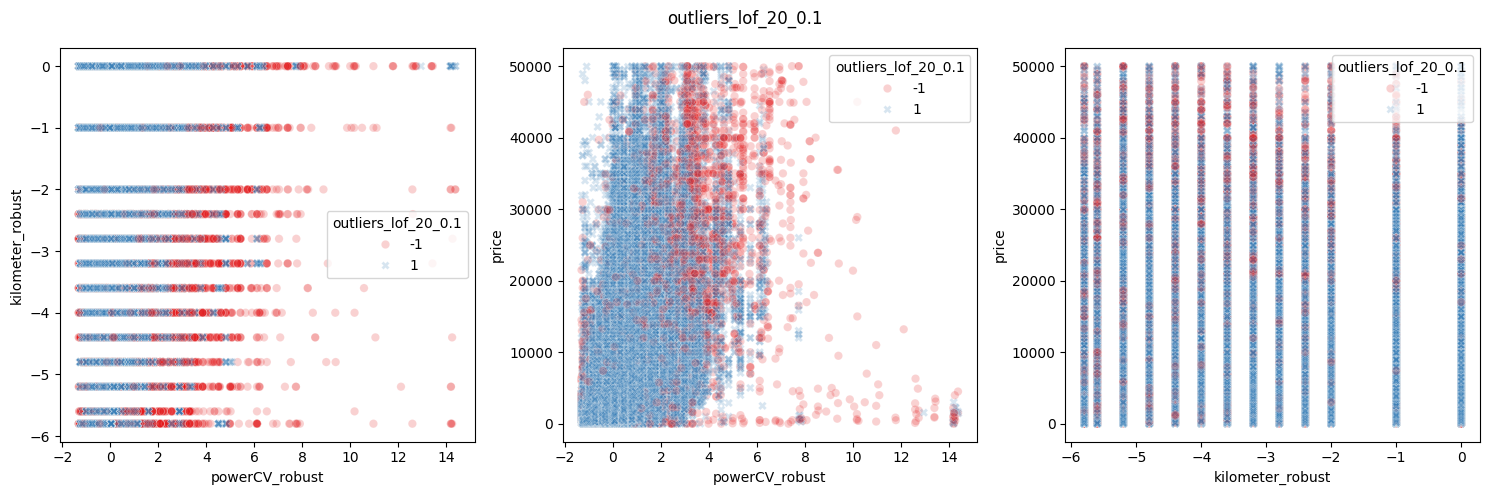

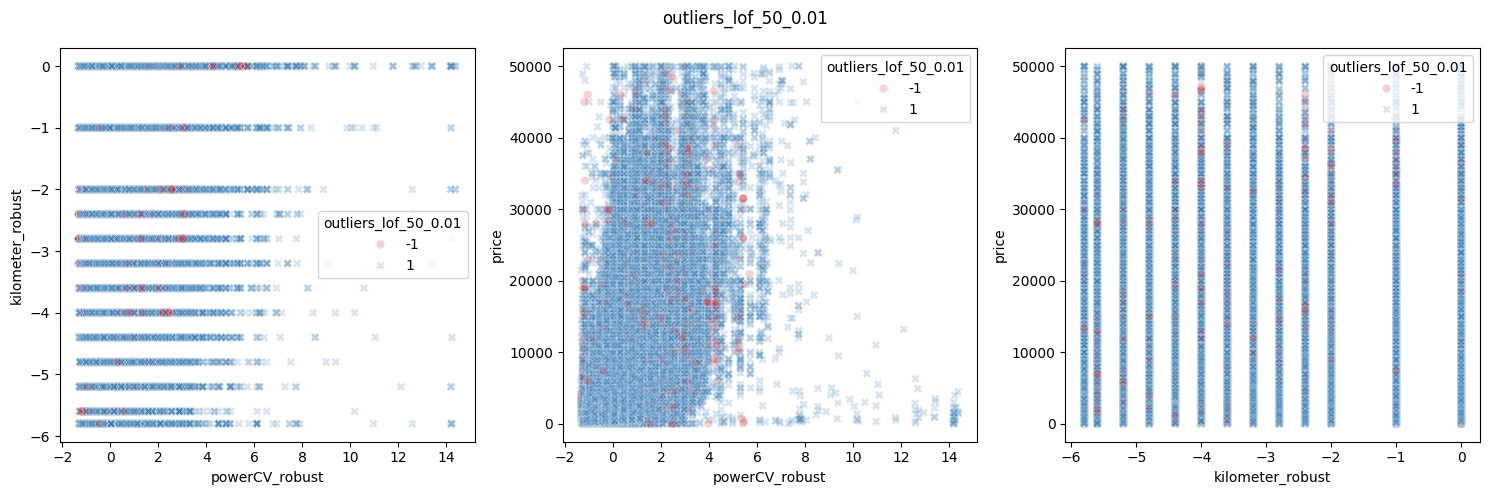

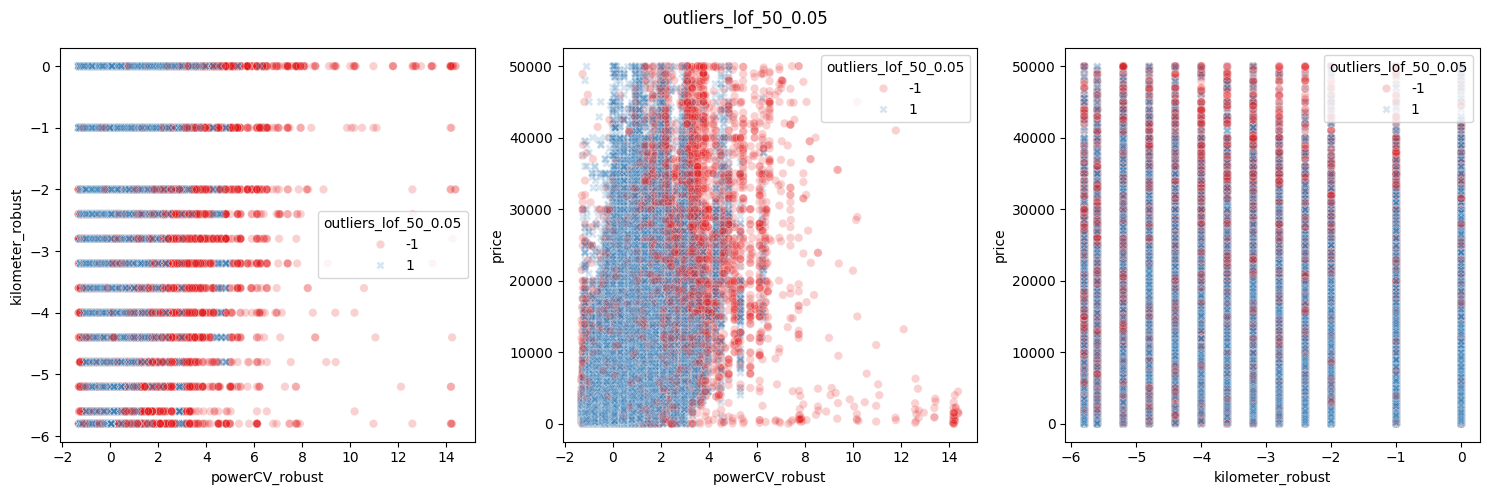

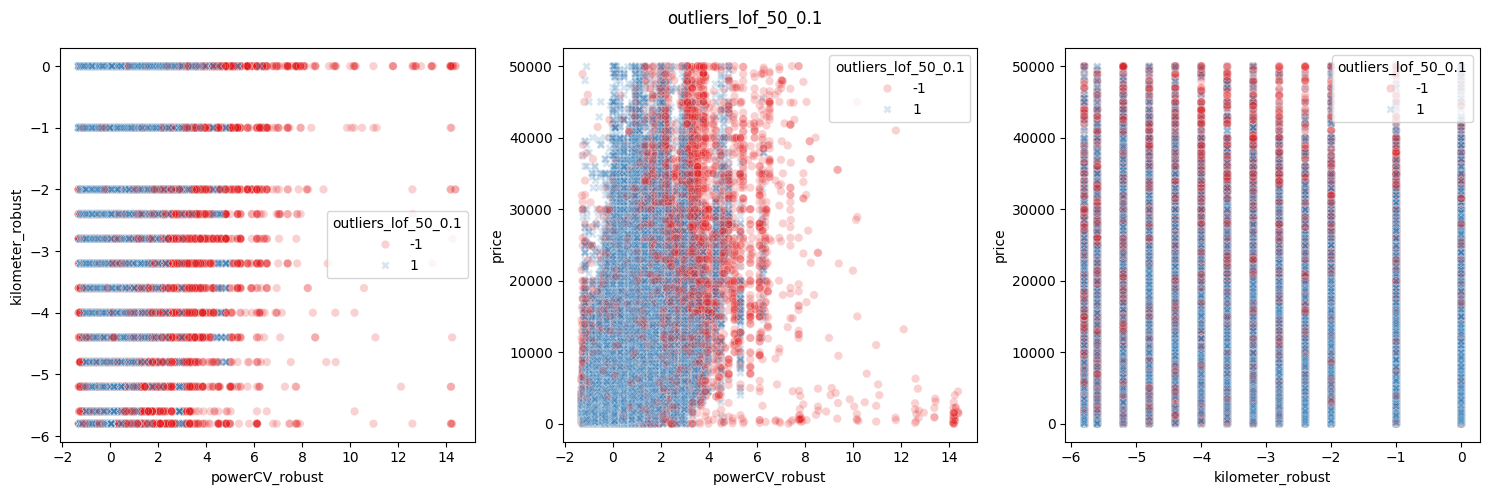

In [7]:
combinaciones_variables = list(combinations(['powerCV_robust', 'kilometer_robust', 'price'], 2))
columnas_hue = df_lof.filter(like="outlier").columns

for col_hue in columnas_hue:
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
    axes = axes.flat

    for indice, tupla in enumerate(combinaciones_variables):
        sns.scatterplot(df_lof, x=tupla[0], y=tupla[1], ax=axes[indice], hue = col_hue, palette="Set1", style=col_hue, alpha=0.2)
        plt.suptitle(f"{col_hue}")
        plt.tight_layout()

In [ ]:
df_lof.to_csv("../datos/df_lof.csv")

Estudiamos los outliers que hemos obtenido:

In [3]:
df_lof = pd.read_csv("../datos/df_lof.csv", index_col=0)

In [4]:
df_lof["porcentaje_outliers"] = df_lof.filter(like="outliers").apply(lambda x: round(sum(x==-1)/len(x),2), axis=1)

In [5]:
df_outliers_60 = df_lof[df_lof["porcentaje_outliers"]>0.6]

In [6]:
df_outliers_60.shape[0]/df_lof.shape[0]

0.010359592854915587

In [23]:
df_outliers_60.head()

dateCrawled                                       name   seller  \
102  2016-03-16 16:44:10  Hyundai_Genesis_Coupe_GT_3.8_V6_Automatik  private   
156  2016-03-23 14:45:57      Kia_Sorento__coole_Farbe_schaut......  private   
186  2016-03-31 16:57:18                     Ford_Mustang_V8_390cui  private   
270  2016-03-21 17:36:59              Renault_Clio_III_Sport_RS_201  private   
286  2016-03-06 12:38:13                               Ford_Mustang  private   

    offerType   abtest vehicleType    gearbox    model  price  \
102     offer  control       coupe  automatic   andere  22999   
156     offer     test         suv  automatic  sorento   7500   
186     offer  control       coupe  automatic  mustang  25000   
270     offer  control   small car   manually     clio   8400   
286     offer     test       coupe  automatic  mustang  18700   

    monthOfRegistration  ... outliers_lof_5_0.01 outliers_lof_5_0.05  \
102               April  ...                  -1                  -1   
156            November  ...                  -1                  -1   
186            November  ...                   1                   1   
270                June  ...                  -1                  -1   
286              August  ...                  -1                  -1   

    outliers_lof_5_0.1 outliers_lof_20_0.01 outliers_lof_20_0.05  \
102                 -1                    1                   -1   
156                 -1                    1                   -1   
186                  1                   -1                   -1   
270                 -1                   -1                   -1   
286                 -1                   -1                   -1   

    outliers_lof_20_0.1  outliers_lof_50_0.01  outliers_lof_50_0.05  \
102                  -1                     1                    -1   
156                  -1                     1                    -1   
186                  -1                    -1                    -1   
270                  -1                    -1                    -1   
286                  -1                    -1                    -1   

     outliers_lof_50_0.1  porcentaje_outliers  
102                   -1                 0.78  
156                   -1                 0.78  
186                   -1                 0.67  
270                   -1                 1.00  
286                   -1                 1.00  

[5 rows x 28 columns]

In [15]:
fs.exploracion_dataframe(df_outliers_60)

El número de datos es 3721 y el de columnas es 28

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


Empty DataFrame
Columns: [%_nulos]
Index: []


 ..................... 

Los tipos de las columnas son:


tipo_dato
dateCrawled             object
name                    object
seller                  object
offerType               object
abtest                  object
vehicleType             object
gearbox                 object
model                   object
price                    int64
monthOfRegistration     object
fuelType                object
brand                   object
notRepairedDamage       object
dateCreated             object
lastSeen                object
tipo_coche              object
powerCV_robust         float64
kilometer_robust       float64
outliers_lof_5_0.01      int64
outliers_lof_5_0.05      int64
outliers_lof_5_0.1       int64
outliers_lof_20_0.01     int64
outliers_lof_20_0.05     int64
outliers_lof_20_0.1      int64
outliers_lof_50_0.01     int64
outliers_lof_50_0.05     int64
outliers_lof_50_0.1      int64
porcentaje_outliers    float64


 ..................... 



count          mean           std       min  \
price                 3721.0  13889.509003  11406.797097  1.000000   
powerCV_robust        3721.0      1.559562      2.297311 -1.311475   
kilometer_robust      3721.0     -3.112335      1.719528 -5.800000   
outliers_lof_5_0.01   3721.0     -0.353400      0.935598 -1.000000   
outliers_lof_5_0.05   3721.0     -0.353400      0.935598 -1.000000   
outliers_lof_5_0.1    3721.0     -0.353400      0.935598 -1.000000   
outliers_lof_20_0.01  3721.0     -0.464123      0.885890 -1.000000   
outliers_lof_20_0.05  3721.0     -0.996775      0.080257 -1.000000   
outliers_lof_20_0.1   3721.0     -0.996775      0.080257 -1.000000   
outliers_lof_50_0.01  3721.0     -0.190540      0.981811 -1.000000   
outliers_lof_50_0.05  3721.0     -0.943564      0.331236 -1.000000   
outliers_lof_50_0.1   3721.0     -0.943564      0.331236 -1.000000   
porcentaje_outliers   3721.0      0.812755      0.130130  0.670000   

                              25%           50%           75%           max  
price                 4800.000000  11200.000000  19900.000000  50000.000000  
powerCV_robust          -0.016393      1.016393      2.639344     14.262295  
kilometer_robust        -4.400000     -3.200000     -2.000000      0.000000  
outliers_lof_5_0.01     -1.000000     -1.000000      1.000000      1.000000  
outliers_lof_5_0.05     -1.000000     -1.000000      1.000000      1.000000  
outliers_lof_5_0.1      -1.000000     -1.000000      1.000000      1.000000  
outliers_lof_20_0.01    -1.000000     -1.000000      1.000000      1.000000  
outliers_lof_20_0.05    -1.000000     -1.000000     -1.000000      1.000000  
outliers_lof_20_0.1     -1.000000     -1.000000     -1.000000      1.000000  
outliers_lof_50_0.01    -1.000000     -1.000000      1.000000      1.000000  
outliers_lof_50_0.05    -1.000000     -1.000000     -1.000000      1.000000  
outliers_lof_50_0.1     -1.000000     -1.000000     -1.000000      1.000000  
porcentaje_outliers      0.670000      0.780000      0.890000      1.000000


 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna DATECRAWLED tiene las siguientes valore únicos:


count
dateCrawled               
2016-03-31 17:46:09      2
2016-03-15 21:38:57      2
2016-04-03 19:47:04      2
2016-04-02 18:49:44      2
2016-03-11 13:55:09      2

La columna NAME tiene las siguientes valore únicos:


count
name                                   
Ford_Mustang                         24
Opel_GT                               8
Ford_Focus_2.5_RS                     6
Chrysler_Sebring_Cabrio_2.7_LX        6
Mercedes_Benz_SLK_230_Kompressor      6

La columna SELLER tiene las siguientes valore únicos:


count
seller        
private   3721

La columna OFFERTYPE tiene las siguientes valore únicos:


count
offerType       
offer       3721

La columna ABTEST tiene las siguientes valore únicos:


count
abtest        
test      1960
control   1761

La columna VEHICLETYPE tiene las siguientes valore únicos:


count
vehicleType           
sin informacion   1170
coupe              521
small car          496
suv                484
convertible        413

La columna GEARBOX tiene las siguientes valore únicos:


count
gearbox               
manually          2013
automatic         1631
sin informacion     77

La columna MODEL tiene las siguientes valore únicos:


count
model                 
andere             726
sin informacion    426
golf               116
3er                 92
c_klasse            75

La columna MONTHOFREGISTRATION tiene las siguientes valore únicos:


count
monthOfRegistration       
July                   403
June                   384
March                  354
April                  343
May                    306

La columna FUELTYPE tiene las siguientes valore únicos:


count
fuelType              
petrol            2777
diesel             599
sin informacion    224
lpg                104
hybrid               9

La columna BRAND tiene las siguientes valore únicos:


count
brand                
mercedes_benz     394
ford              300
volkswagen        288
sonstige_autos    284
audi              283

La columna NOTREPAIREDDAMAGE tiene las siguientes valore únicos:


count
notRepairedDamage       
no                  2911
sin informacion      543
yes                  267

La columna DATECREATED tiene las siguientes valore únicos:


count
dateCreated               
2016-03-15 00:00:00    156
2016-04-03 00:00:00    152
2016-03-08 00:00:00    147
2016-03-07 00:00:00    143
2016-04-04 00:00:00    137

La columna LASTSEEN tiene las siguientes valore únicos:


count
lastSeen                  
2016-04-07 07:15:30      3
2016-04-06 10:17:09      3
2016-04-06 04:15:29      3
2016-04-06 19:17:01      2
2016-04-06 02:44:24      2

La columna TIPO_COCHE tiene las siguientes valore únicos:


count
tipo_coche            
Moderno Clásico   2686
Joven Clásico      572
Moderno            262
Clásico            191
Sin registro         8

<Axes: xlabel='kilometer_robust', ylabel='price'>

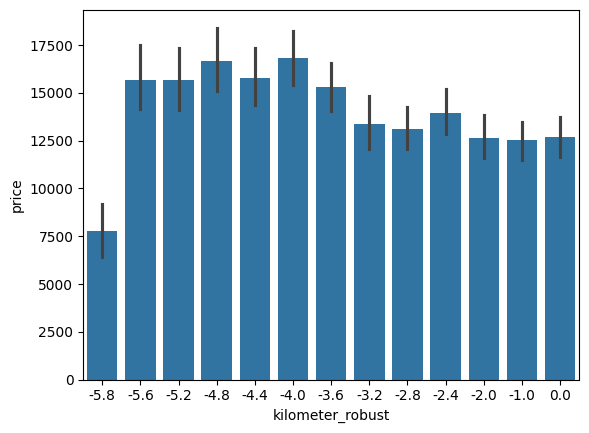

In [20]:
sns.barplot(df_outliers_60, x="kilometer_robust", y="price")

<Axes: xlabel='powerCV_robust', ylabel='Count'>

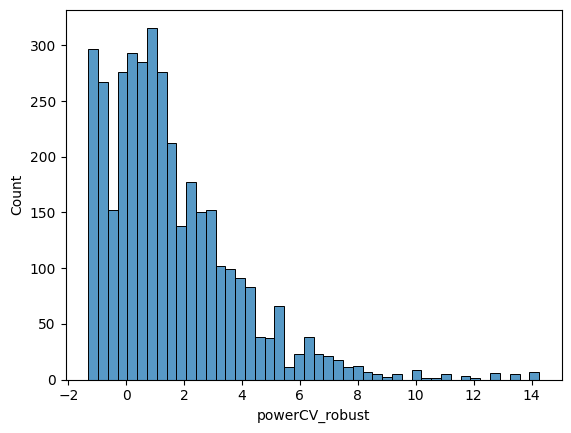

In [22]:
sns.histplot(df_outliers_60, x="powerCV_robust")

Una vez estudiados los datos no tenemos evidencias suficientes como para eliminar los outliers y nos interesa mantenerlos por lo que sustituimos kilometer_robust y powerCV_robust por sus medianas respectivas ya que al tener muchos datos extremos afectan a la media y por eso elegimos la mediana.

In [31]:
df_describe = df_lof.describe().T
mediana_powerCV = df_describe.loc["powerCV_robust", "50%"]
mediana_kilometros = df_describe.loc["kilometer_robust", "50%"]

In [32]:
df_lof[df_lof["porcentaje_outliers"]>0.6]["powerCV_robust"]=mediana_powerCV
df_lof[df_lof["porcentaje_outliers"]>0.6]["kilometer_robust"]=mediana_kilometros

In [37]:
df_sin_outliers = df_lof[['dateCrawled', 'name', 'seller', 'offerType', 'abtest', 'vehicleType',
       'gearbox', 'model', 'price', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'lastSeen', 'tipo_coche',
       'powerCV_robust', 'kilometer_robust']]
df_sin_outliers.head()

dateCrawled                            name   seller offerType  \
0  2016-03-24 11:52:17                      Golf_3_1.6  private     offer   
1  2016-03-24 10:58:45            A5_Sportback_2.7_Tdi  private     offer   
2  2016-03-14 12:52:21  Jeep_Grand_Cherokee_"Overland"  private     offer   
3  2016-03-17 16:54:04              GOLF_4_1_4__3TÜRER  private     offer   
4  2016-03-31 17:25:20  Skoda_Fabia_1.4_TDI_PD_Classic  private     offer   

  abtest      vehicleType    gearbox            model  price  \
0   test  sin informacion   manually             golf    480   
1   test            coupe   manually  sin informacion  18300   
2   test              suv  automatic            grand   9800   
3   test        small car   manually             golf   1500   
4   test        small car   manually            fabia   3600   

  monthOfRegistration fuelType       brand notRepairedDamage  \
0     sin informacion   petrol  volkswagen   sin informacion   
1                 May   diesel        audi               yes   
2              August   diesel        jeep   sin informacion   
3                June   petrol  volkswagen                no   
4                July   diesel       skoda                no   

           dateCreated             lastSeen       tipo_coche  powerCV_robust  \
0  2016-03-24 00:00:00  2016-04-07 03:16:57    Joven Clásico        0.072957   
1  2016-03-24 00:00:00  2016-04-07 01:46:50  Moderno Clásico        1.098361   
2  2016-03-14 00:00:00  2016-04-05 12:47:46  Moderno Clásico        0.672131   
3  2016-03-17 00:00:00  2016-03-17 17:40:17  Moderno Clásico       -0.754098   
4  2016-03-31 00:00:00  2016-04-06 10:17:21  Moderno Clásico       -0.852459   

   kilometer_robust  
0               0.0  
1              -1.0  
2              -1.0  
3               0.0  
4              -2.4

In [38]:
df_sin_outliers.to_csv("../datos/df_sin_outliers.csv")